# Analyse sample movies separately

22.09.2022

In questo script implemento il codice per controllare manualmente i singoli video, i.e., li apro con Napari e vedo cosa c'è che non va nelle preds.

Cose da controllare:
- base: video originale
- binary class preds vs. binary class annotations (con almeno 2 threshold automatici: Otsu e un altro)
- proba class preds vs. binary class annotations (magari nello stesso Napari viewer del precedente, per vedere se eventi corretti sono tranciati via dal threshold)
- controllare se ci sono molti eventi nelle preds che sono molto piccoli (waves in particolare; provare poi a rimuoverli nello script `PREDS PROCESSING separate events.ipynb` per separare gli eventi e vedere come cambiano i valori nelle confusion matrices)
- controllare quanto spesso sparks e puffs sono scambiati
- dare prima un'occhiata alla confusion matrix (in `PREDS PROCESSING separate events.ipynb`) per vedere se i "problemi nei numeri" sono effettivamente presenti nelle preds

# TODO  
(as of 05/10/23)

Bisogna ancora definire la funzione `get_puff_signal` (alla fine di questo script).

In [1]:
# autoreload is used to reload modules automatically before entering the
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2
# To import modules from parent directory in Jupyter Notebook
import sys

sys.path.append("..")

In [3]:
import numpy as np
import os
import imageio
import napari
import matplotlib.pyplot as plt
from matplotlib import cm
import math

from scipy import ndimage as ndi

from utils.in_out_tools import load_annotations_ids
from data.data_processing_tools import (
    detect_spark_peaks,
    get_separated_events,
    get_otsu_argmax_segmentation,
)
from utils.visualization_tools import (
    get_discrete_cmap,
    get_spark_signal,
    get_spark_2d_signal,
)

In [4]:
BASEDIR = os.path.abspath("")
BASEDIR

'c:\\Users\\prisc\\Code\\sparks_project\\sparks'

## Load predictions

Load predictions from files generated when running the test function during training.

They are saved in `runs\<training_name>\predictions` and the filename template is `<training_name>_<movie_id>_<preds class/xs/ys/...>.tif`.

The epoch is not explicitly mentionned, but it depends on the last epoch of the last model that has been run.

In [7]:
# assuming these are the movie IDs whose predictions are available...
# movie_ids = ["05","10","15","20","25","32","34","40","45"]
movie_ids = ["05", "34"]

### Select training name to load

In [8]:
training_name = "TEMP_new_annotated_peaks_physio"

### Configure input & output directory

In [9]:
data_dir = os.path.join("runs", training_name, "predictions")
out_dir = "trainings_validation"

### Load movies, annotations and predictions

In [10]:
### Load movies
xs_filenames = {
    movie_id: os.path.join(data_dir, training_name + "_" + movie_id + "_xs.tif")
    for movie_id in movie_ids
}
xs = {movie_id: np.asarray(imageio.volread(f)) for movie_id, f in xs_filenames.items()}

### Load annotations
# Annotations used during training (from predictions folder)

ys_filenames = {
    movie_id: os.path.join(data_dir, training_name + "_" + movie_id + "_ys.tif")
    for movie_id in movie_ids
}
ys = {
    movie_id: np.asarray(imageio.volread(f)).astype("int")
    for movie_id, f in ys_filenames.items()
}

### Load annotated event instances
dataset_dir = os.path.join("..", "data", "sparks_dataset")
annotated_events = load_annotations_ids(
    data_folder=dataset_dir, ids=movie_ids, mask_names="event_label"
)

### Load predictions
# Predictions created from selected model

sparks_filenames = {
    movie_id: os.path.join(data_dir, training_name + "_" + movie_id + "_sparks.tif")
    for movie_id in movie_ids
}
puffs_filenames = {
    movie_id: os.path.join(data_dir, training_name + "_" + movie_id + "_puffs.tif")
    for movie_id in movie_ids
}
waves_filenames = {
    movie_id: os.path.join(data_dir, training_name + "_" + movie_id + "_waves.tif")
    for movie_id in movie_ids
}

sparks = {
    movie_id: np.asarray(imageio.volread(f)) for movie_id, f in sparks_filenames.items()
}
puffs = {
    movie_id: np.asarray(imageio.volread(f)) for movie_id, f in puffs_filenames.items()
}
waves = {
    movie_id: np.asarray(imageio.volread(f)) for movie_id, f in waves_filenames.items()
}

FileNotFoundError: No such file: 'c:\Users\prisc\Code\sparks_project\sparks\runs\TEMP_new_annotated_peaks_physio\predictions\TEMP_new_annotated_peaks_physio_05_xs.tif'

### Functions and global parameters

In [10]:
# Configure Napari cmap
cmap = get_discrete_cmap(name="gray", lut=16)

In [11]:
PIXEL_SIZE = 0.2  # 1 pixel = 0.2 um x 0.2 um
global MIN_DIST_XY
MIN_DIST_XY = round(1.8 / PIXEL_SIZE)  # min distance in space between sparks
TIME_FRAME = 6.8  # 1 frame = 6.8 ms
global MIN_DIST_T
MIN_DIST_T = round(20 / TIME_FRAME)  # min distance in time between sparks

In [12]:
# parameters for puffs and waves CCs detection
connectivity = 26

In [13]:
# parameters for spark peaks detection
radius = math.ceil(MIN_DIST_XY / 2)
y, x = np.ogrid[-radius : radius + 1, -radius : radius + 1]
disk = x**2 + y**2 <= radius**2
connectivity_mask = np.stack([disk] * (MIN_DIST_T), axis=0)

sigma = 3

# Visualise preds in a sample movie (without separating them)

In [14]:
sample_id = "45"

In [15]:
sample = {"xs": xs[sample_id], "ys": ys[sample_id]}

preds = {
    "sparks": sparks[sample_id],
    "puffs": puffs[sample_id],
    "waves": waves[sample_id],
    "background": 1 - sparks[sample_id] - puffs[sample_id] - waves[sample_id],
}

### Visualize % of preds that belongs to each class

In [16]:
stacked_sample_preds = np.array(
    [preds["background"], preds["sparks"], preds["waves"], preds["puffs"]]
)

In [17]:
viewer = napari.Viewer()

viewer.add_image(sample["xs"], name="movie", colormap=("colors", cmap), visible=False)

viewer.add_image(
    stacked_sample_preds,
    name=[
        "predicted background",
        "predicted sparks",
        "predicted waves",
        "predicted puffs",
    ],
    colormap=["gray", "bop orange", "cyan", "magenta"],
    channel_axis=0,
)

viewer.add_labels(sample["ys"], name="annotated segmentation", opacity=0.5)

C:\Users\dotti\.conda\envs\sparks\lib\site-packages\napari\_qt\__init__.py:54: UserWarning: 

IMPORTANT:
You are using QT version 5.9.7, but version 5.15.6 was also found in your environment.
This usually happens when you 'conda install' something that also depends on PyQt
*after* you have pip installed napari (such as jupyter notebook).
You will likely run into problems and should create a fresh environment.
If you want to install conda packages into the same environment as napari,
please add conda-forge to your channels: https://conda-forge.org

  warn(message=warn_message)


<Labels layer 'annotated segmentation' at 0x1ee0aa884f0>

## Get argmax segmentation

Using Otsu threshold on summed predictions

In [18]:
argmax_preds, classes_preds = get_otsu_argmax_segmentation(
    preds=preds, return_classes=True, debug=True
)

	Events detection threshold: 0.72820866


In [19]:
viewer.add_labels(classes_preds, name="binary predicted classes", opacity=0.5)

<Labels layer 'binary predicted classes' at 0x1ecc1bf4eb0>

## Separate events in predictions

In [20]:
separated_events, sparks_loc = get_separated_events(
    argmax_preds=argmax_preds,
    movie=sample["xs"],
    debug=True,
)

Number of sparks detected by nonmaxima suppression: 40
Not all sparks were labelled, computing missing events...
Number of sparks before correction: 40
Number of sparks after correction: 42


In [21]:
viewer2 = napari.Viewer()
viewer2.add_image(sample["xs"], name="movie", colormap=("colors", cmap))

for class_name, class_events in separated_events.items():
    viewer2.add_labels(class_events, name=class_name, opacity=0.5)

In [22]:
viewer2.add_labels(
    argmax_preds["sparks"], name="predicted binary sparks", opacity=0.5, visible=False
)

viewer2.add_points(sparks_loc, name="predictes spark peaks", size=5, visible=False)

<Points layer 'predictes spark peaks' at 0x1ee1793c8e0>

### Compute spark peaks in predicted events

In [23]:
coords_pred = detect_spark_peaks(
    movie=sample["xs"],
    instances_mask=separated_events["sparks"],
    sigma=2,
    max_filter_size=10,
    return_mask=False,
)

len(coords_pred)

42

In [24]:
viewer2.add_points(
    coords_pred,
    name="predictes spark peaks detected after separating sparks",
    size=5,
    face_color="blue",
    visible=False,
)

<Points layer 'predictes spark peaks detected after separating sparks' at 0x1ee17a6f190>

## Visualise interesting single events

E.g., signal in time and 3D profile of FP sparks etc.

- If considering sparks: can use peak of event as a reference for the plots
- Otherwise, compute averaged signal in time

### SPARKS

#### get 1D signal for every spark centre

In [166]:
# define smooth input movie used for plotting
new_smooth_xs = ndi.gaussian_filter(sample["xs"], sigma=1)

In [167]:
radius = 4
context_duration = 20

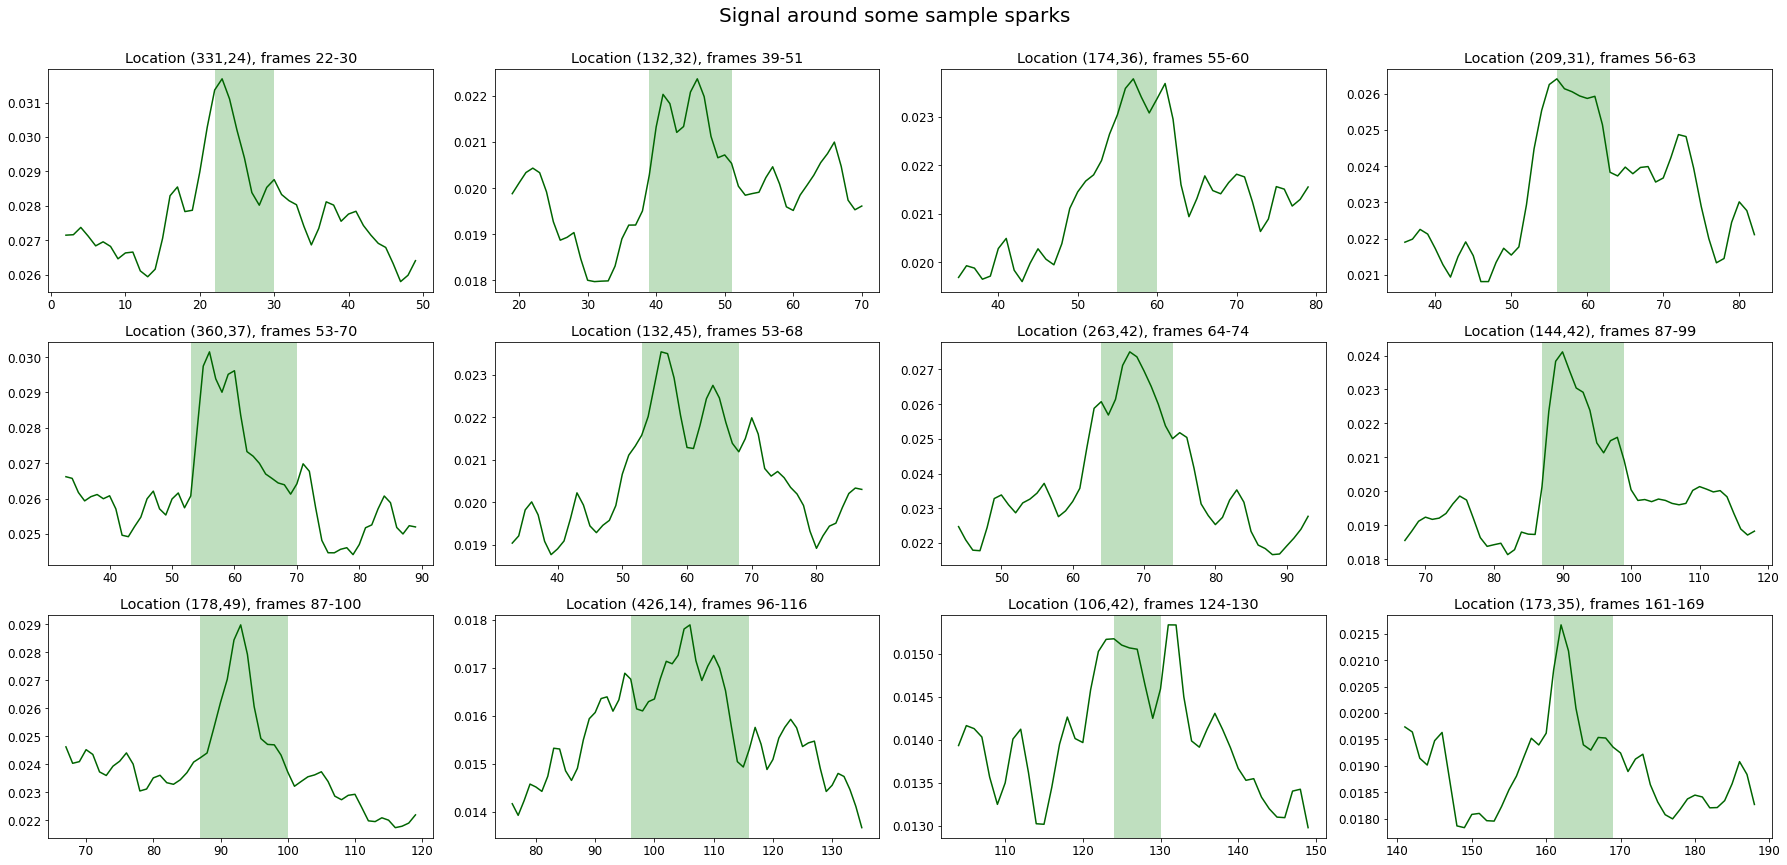

In [168]:
# Plot a few predicted signal samples

# num_samples = len(coords_pred)
num_samples = 12

plt.rcParams.update({"font.size": 12})

plt.figure(figsize=(25, num_samples))
plt.suptitle("Signal around some sample sparks", fontsize=20, y=1)

for idx, centre in enumerate(coords_pred[:num_samples]):
    frames, signal, (y, x), start, stop = get_spark_signal(
        video=new_smooth_xs,
        sparks_labelled=separated_events["sparks"],
        center=centre,
        radius=radius,
        context_duration=context_duration,
        return_info=True,
    )

    # print(idx)
    # print("frames",len(frames))
    # print("signal",len(signal))
    # print("centre",centre)
    # print("start",start,"stop",stop,"diff",stop-start)
    # break
    ax = plt.subplot(math.ceil(num_samples / 4), 4, idx + 1)
    ax.set_title(f"Location ({x},{y}), frames {start}-{stop}")
    ax.axvspan(start, stop, facecolor="green", alpha=0.25)
    plt.plot(frames, signal, color="darkgreen")

plt.tight_layout()
plt.show()

#### get 2D signal around center of each spark (for shape analysis)

In [169]:
# pick sample event
event_idx = 8  # event_idx = 1,2,...,n_sparks
spatial_context = 10  # consider extended ROI

In [171]:
n_sparks = len(coords_pred)

In [172]:
# compute single ROIs
sparks_rois = ndi.measurements.find_objects(separated_events["sparks"])
# i-th element correspond to event with index i+1

In [173]:
# assign a ROI (slices) to each centre
slices_spark_centres = []
for t, y, x in coords_pred:
    event_nb = separated_events["sparks"][t, y, x]
    slices_spark_centres.append(sparks_rois[event_nb - 1])

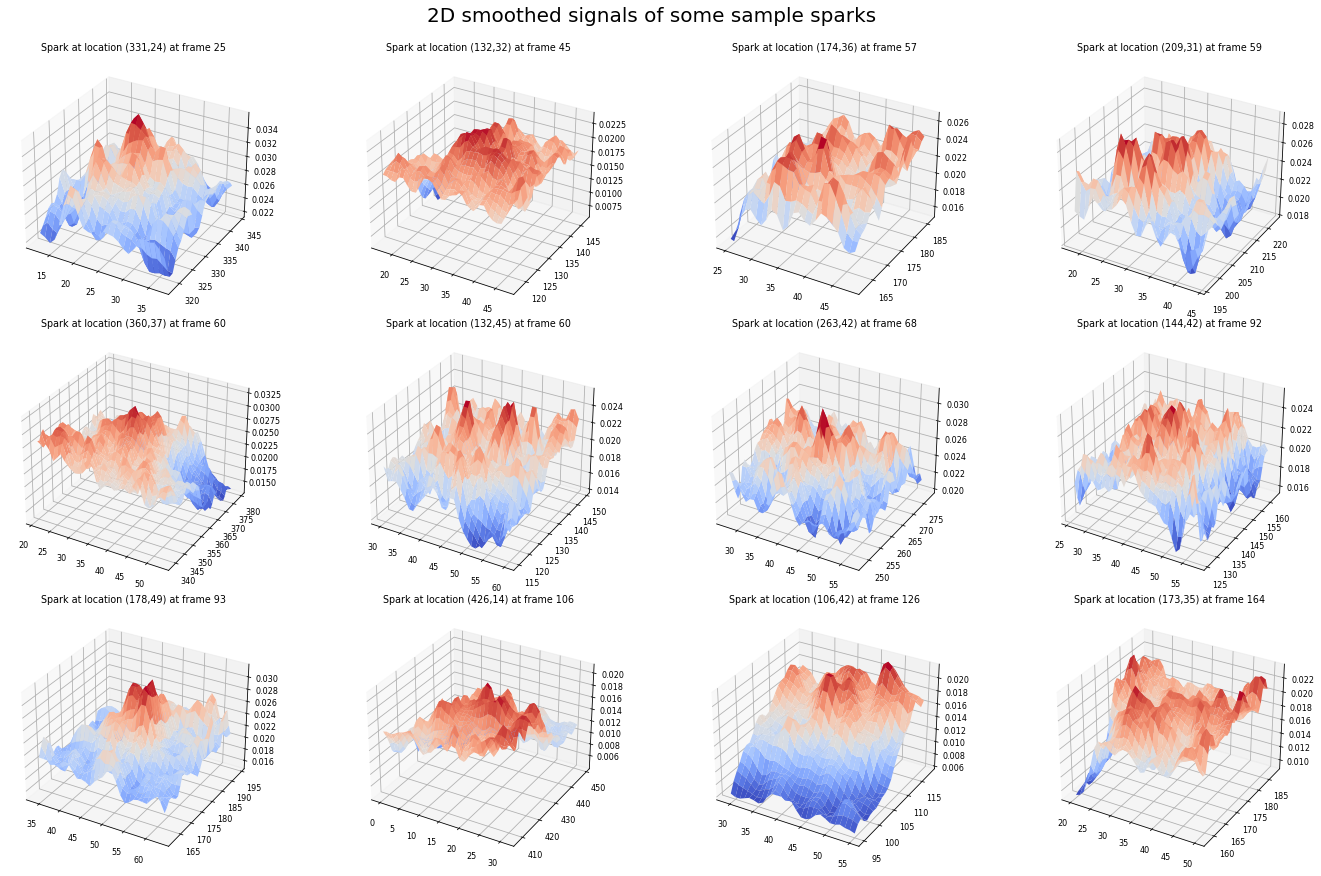

In [174]:
# Plot 2D signal

# num_plots = n_sparks

num_plots = 12

plt.figure(figsize=(20, num_plots))

# if n_sparks == 1:
#    plt.suptitle("2D smoothed signal of a sample spark", fontsize=10)
#    idx = 1

#    t,y,x,y_axis,x_axis,signal_2d = get_spark_2d_signal(video_array,
#                                                        slices_spark_centres[idx-1],
#                                                        coords_spark_centres[idx-1],
#                                                        spatial_context,
#                                                        sigma = 2,
#                                                        return_info = True)
#
#    x_axis, y_axis = np.meshgrid(x_axis,y_axis)

#    ax = plt.subplot(1,1,idx, projection='3d')
#    ax.set_title(f"Spark at location ({x},{y}) at frame {t}")
#    ax.plot_surface(y_axis, x_axis, signal_2d, cmap=cm.coolwarm, linewidth=0)#, antialiased=False)
# else:
plt.suptitle("2D smoothed signals of some sample sparks", fontsize=20, y=1)
plt.rcParams.update({"font.size": 8})

for idx in range(1, num_plots + 1):
    n_rows = num_plots // 4 if num_plots % 4 == 0 else (num_plots // 4) + 1
    t, y, x, y_axis, x_axis, signal_2d = get_spark_2d_signal(
        video=new_smooth_xs,
        slices=slices_spark_centres[idx - 1],
        coords=coords_pred[idx - 1],
        spatial_context=spatial_context,
        sigma=2,
        return_info=True,
    )

    x_axis, y_axis = np.meshgrid(x_axis, y_axis)

    ax = plt.subplot(n_rows, 4, idx, projection="3d")
    ax.set_title(f"Spark at location ({x},{y}) at frame {t}")
    ax.plot_surface(
        y_axis, x_axis, signal_2d, cmap=cm.coolwarm, linewidth=0
    )  # , antialiased=False)

plt.tight_layout()
plt.show()

### PUFFS (and maybe waves) --> TO DO

In [138]:
puff_ids = np.unique(separated_events["puffs"])
puff_ids = puff_ids[puff_ids != 0]
print("Puff indices:", puff_ids)

Puff indices: [ 1  2  3  4  5  6  7  8  9 10]


In [139]:
def get_puff_signal(
    video, puffs_labelled, event_id, context_duration, return_info=False
):
    # video:             is the original video sample
    # puffs_labelled:    is a mask containing the segmentation of the
    #                    puff events (1 integer for every event)
    # event_id:          id of the event to plot
    # context_duration:  is the number of frames included in the analysis before
    #                    and after the event

    event_mask = puffs_labelled == event_id
    loc = ndi.measurements.find_objects(event_mask)[0]
    assert loc[0].start <= t and loc[0].stop > t, "something weird is wrong"

    # get mask representing puff location (with radius and context)
    start = loc[0].start - context_duration
    stop = loc[0].stop + context_duration

    # start = max(0,start)
    # stop = min(video.shape[0],stop)
    # signal_mask = create_signal_mask(*sparks_labelled.shape,
    #                                 start, stop,
    #                                 (x,y), radius)

    # frames = np.arange(start,stop)
    # signal = np.average(video[start:stop],
    #                    axis=(1,2),
    #                    weights=signal_mask[start:stop])

    # if return_info:
    #    return frames, signal, (y,x), loc[0].start, loc[0].stop

    # return frames, signal

In [140]:
context_duration = 20

In [55]:
puff_id = 1

In [56]:
get_puff_signal(
    video=new_smooth_xs,
    puffs_labelled=separated_events["puffs"],
    event_id=puff_id,
    context_duration=context_duration,
    return_info=False,
)

separated_events["puffs"]

AssertionError: something weird is wrong

In [ ]:
np.unique(separated_events["puffs"])